In [6]:
import h5py
import numpy as np
import pandas as pd 

import fastdtw
import scipy.spatial.distance as sd

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('whitegrid')

GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740
PLOT_MASK = range(1475,1550)

In [56]:
original_masked = pd.read_csv("/home/pravn/Documents/original_masked_ew_sobject_id_3.csv")

In [57]:
original_masked["sobject_id"].count()

588344

In [58]:
unproblem_ids = pd.read_csv("/home/pravn/Dropbox/unproblem_ids.csv",index_col=0)

In [59]:
df_temp = pd.merge(original_masked , unproblem_ids, how='outer', indicator=True, on="sobject_id")

In [60]:
df_temp["_merge"].value_counts()

both          356299
left_only     232045
right_only         0
Name: _merge, dtype: int64

In [61]:
good_ids = df_temp.loc[df_temp["_merge"]=="both"]

In [62]:
good_ids.head()

,sobject_id,1475,1476,1477,1478,1479,1480,1481,1482,1483,...,1542,1543,1544,1545,1546,1547,1548,1549,EW,_merge
0,131116000501002,1.002929,1.020100,1.024491,1.022349,1.012781,0.992014,0.972579,0.980616,1.017553,...,1.010591,0.986887,0.998070,1.034840,1.039356,1.017275,1.003299,0.992692,-0.037339,both
2,131116000501005,0.852568,0.855619,0.852560,0.847285,0.843284,0.833912,0.815157,0.815373,0.822885,...,0.837705,0.847344,0.861569,0.875073,0.886794,0.884729,0.878885,0.859658,-0.094523,both
3,131116000501006,0.799966,0.805414,0.790533,0.784372,0.764509,0.766564,0.785371,0.782442,0.776574,...,0.820822,0.824237,0.821758,0.825028,0.833799,0.852333,0.860145,0.859907,-0.087229,both
4,131116000501007,0.762165,0.753905,0.756847,0.772023,0.768651,0.756399,0.747767,0.750086,0.752324,...,0.830479,0.826671,0.820743,0.815063,0.803316,0.793477,0.788137,0.810344,0.076844,both
7,131116000501012,0.820555,0.817926,0.820356,0.820411,0.803494,0.785131,0.780252,0.787406,0.796942,...,0.834277,0.853729,0.873623,0.871357,0.868724,0.857287,0.847043,0.857832,-0.009553,both


In [112]:
good_ids_masked = good_ids[good_ids["EW"]>0.1]

In [113]:
good_ids_masked["EW"].describe()

count    11147.000000
mean         0.210541
std          0.170146
min          0.100007
25%          0.120153
50%          0.153175
75%          0.228987
max          3.588870
Name: EW, dtype: float64

In [69]:
good_ids_masked_01_data_only = good_ids_masked.drop(columns=['EW','sobject_id','_merge'])

In [71]:
good_ids_masked_01_data_only_np = good_ids_masked_01_data_only.to_numpy()

In [72]:
def my_fastdtw(spec1, spec2):
    return fastdtw.fastdtw(spec1, spec2)[0]

In [73]:
distance_matrix = sd.pdist(good_ids_masked_01_data_only_np, my_fastdtw)

In [74]:
distance_matrix_square_form = sd.squareform(distance_matrix)

In [75]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("Sample")
    plt.ylabel("Sample")
    plt.title("DTW Distance")
    plt.grid()
    plt.legend
    plt.colorbar();

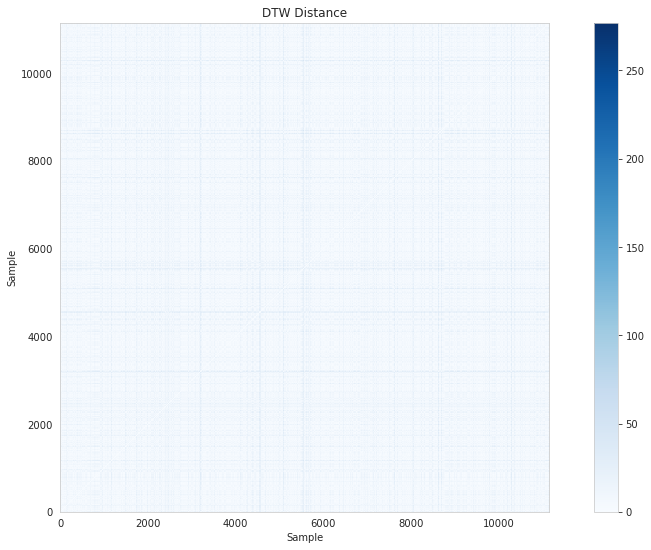

In [76]:
distance_cost_plot(distance_matrix_square_form)

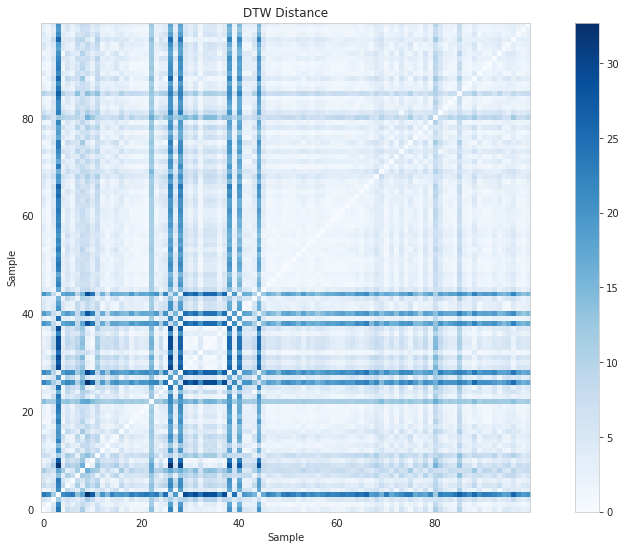

In [77]:
distance_cost_plot(distance_matrix_square_form[0:100:,0:100])

In [78]:
agglom = AgglomerativeClustering(n_clusters = 10, linkage = 'complete', affinity='precomputed')
agglom.fit(distance_matrix_square_form)
agglom.labels_

array([2, 2, 2, ..., 2, 1, 2])

In [79]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [81]:
score = silhouette_score(good_ids_masked_01_data_only_np, agglom.labels_)
print(score)

0.2925948390903534


In [83]:
old_names = good_ids_masked_01_data_only.columns.tolist()

In [85]:
hf_grid = h5py.File("/home/pravn/Dropbox/Masters/Research Data/wl_grid.h5", "r")
wl_grid = np.array(hf_grid["wl_grid"])

In [86]:
new_names = wl_grid[PLOT_MASK].tolist()

In [87]:
col_rename_dict = {i:j for i,j in zip(old_names, new_names)}

In [88]:
good_ids_masked_01_data_only.rename(columns=col_rename_dict, inplace=True)

In [89]:
good_ids_masked_01_data_only.head()

,6561.00,6561.06,6561.12,6561.18,6561.24,6561.30,6561.36,6561.42,6561.48,6561.54,...,6564.90,6564.96,6565.02,6565.08,6565.14,6565.20,6565.26,6565.32,6565.38,6565.44
504,0.883819,0.895194,0.893789,0.882276,0.880220,0.880142,0.876028,0.873322,0.865251,0.853221,...,0.887355,0.868614,0.863716,0.868034,0.886765,0.911001,0.919630,0.916205,0.919868,0.925224
526,0.925995,0.937425,0.931122,0.943284,0.949869,0.945395,0.938096,0.931537,0.924253,0.914655,...,0.930758,0.942894,0.960976,0.960075,0.950048,0.948645,0.936485,0.941481,0.924152,0.903017
528,1.029222,1.025612,1.022917,1.001039,1.001394,1.017275,1.026876,1.020909,1.014809,1.006958,...,1.003887,1.003111,0.997216,0.983768,0.979104,0.997172,1.014369,1.010224,1.000563,0.982823
631,0.990615,0.999885,1.005374,1.006351,0.980763,0.981750,0.998437,0.988112,0.986611,0.978984,...,0.983445,0.964968,0.974401,0.997825,0.991588,0.983049,0.982681,0.966851,0.977266,0.999890
826,0.890529,0.908475,0.906883,0.898805,0.898550,0.895978,0.889900,0.888481,0.890637,0.885473,...,0.916622,0.926633,0.929893,0.926185,0.928854,0.937615,0.942018,0.936143,0.925447,0.918228


In [90]:
good_ids_masked_01_data_only["label"] = pd.Series(agglom.labels_, index = good_ids_masked_01_data_only.index)

In [91]:
good_ids_masked_01_data_only

,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,6561.540000000594,...,6564.960000000617,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label
504,0.883819,0.895194,0.893789,0.882276,0.880220,0.880142,0.876028,0.873322,0.865251,0.853221,...,0.868614,0.863716,0.868034,0.886765,0.911001,0.919630,0.916205,0.919868,0.925224,2
526,0.925995,0.937425,0.931122,0.943284,0.949869,0.945395,0.938096,0.931537,0.924253,0.914655,...,0.942894,0.960976,0.960075,0.950048,0.948645,0.936485,0.941481,0.924152,0.903017,2
528,1.029222,1.025612,1.022917,1.001039,1.001394,1.017275,1.026876,1.020909,1.014809,1.006958,...,1.003111,0.997216,0.983768,0.979104,0.997172,1.014369,1.010224,1.000563,0.982823,2
631,0.990615,0.999885,1.005374,1.006351,0.980763,0.981750,0.998437,0.988112,0.986611,0.978984,...,0.964968,0.974401,0.997825,0.991588,0.983049,0.982681,0.966851,0.977266,0.999890,8
826,0.890529,0.908475,0.906883,0.898805,0.898550,0.895978,0.889900,0.888481,0.890637,0.885473,...,0.926633,0.929893,0.926185,0.928854,0.937615,0.942018,0.936143,0.925447,0.918228,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588252,0.870243,0.865243,0.862632,0.854122,0.865938,0.882183,0.875465,0.856610,0.848073,0.840035,...,0.853007,0.835741,0.837239,0.889354,0.897108,0.891066,0.905483,0.914107,0.907843,2
588289,0.791249,0.776798,0.764736,0.752228,0.753110,0.753602,0.744209,0.752097,0.779056,0.774969,...,0.804217,0.801483,0.806761,0.810920,0.830676,0.824230,0.822123,0.838456,0.844257,1
588296,0.871617,0.875874,0.863571,0.856481,0.861602,0.865315,0.857608,0.848646,0.847804,0.833755,...,0.886094,0.881394,0.869421,0.862949,0.860141,0.865431,0.888157,0.904219,0.886789,2
588301,0.733232,0.725523,0.738103,0.730658,0.730859,0.732629,0.730935,0.723090,0.684995,0.669510,...,0.747718,0.751128,0.758153,0.752169,0.742016,0.750242,0.772734,0.783973,0.775651,1


In [92]:
good_ids_masked_01_data_only["sobject_id"] = good_ids_masked["sobject_id"]

In [93]:
good_ids_masked_01_data_only.head()

,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,6561.540000000594,...,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label,sobject_id
504,0.883819,0.895194,0.893789,0.882276,0.880220,0.880142,0.876028,0.873322,0.865251,0.853221,...,0.863716,0.868034,0.886765,0.911001,0.919630,0.916205,0.919868,0.925224,2,131118002901092
526,0.925995,0.937425,0.931122,0.943284,0.949869,0.945395,0.938096,0.931537,0.924253,0.914655,...,0.960976,0.960075,0.950048,0.948645,0.936485,0.941481,0.924152,0.903017,2,131118002901237
528,1.029222,1.025612,1.022917,1.001039,1.001394,1.017275,1.026876,1.020909,1.014809,1.006958,...,0.997216,0.983768,0.979104,0.997172,1.014369,1.010224,1.000563,0.982823,2,131118002901240
631,0.990615,0.999885,1.005374,1.006351,0.980763,0.981750,0.998437,0.988112,0.986611,0.978984,...,0.974401,0.997825,0.991588,0.983049,0.982681,0.966851,0.977266,0.999890,8,131118003401110
826,0.890529,0.908475,0.906883,0.898805,0.898550,0.895978,0.889900,0.888481,0.890637,0.885473,...,0.929893,0.926185,0.928854,0.937615,0.942018,0.936143,0.925447,0.918228,2,131119001201059


In [94]:
good_ids_masked_01_data_only["label"].value_counts()

2    7350
1    3504
8     181
6      44
0      39
4      16
3       9
9       2
7       1
5       1
Name: label, dtype: int64

In [95]:
df_masked = good_ids_masked_01_data_only

Int64Index([  4701,  39609,  42264,  89645,  89777,  91491, 118924, 121084,
            136767, 152107, 153281, 153416, 154530, 155197, 155918, 156510,
            156660, 156689, 157291, 157313, 157927, 158639, 158915, 158972,
            159284, 170821, 174519, 174550, 174563, 174621, 174658, 304827,
            320685, 322014, 322371, 346407, 354105, 446271, 476947, 542416,
            545114, 545228, 545456, 547366],
           dtype='int64')


Text(6562.78, 2.5, 'Hα')

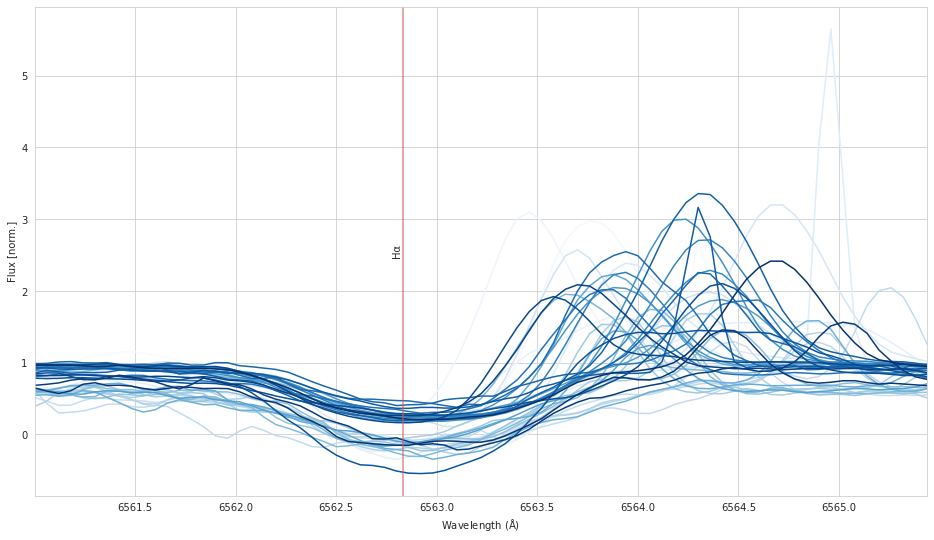

In [117]:
CLASS = 6
df_masked_label = df_masked.loc[df_masked["label"]==CLASS]
print(df_masked_label.index)
ax = (df_masked.loc[df_masked['label'] == CLASS].drop(columns=['label','sobject_id']).T).plot(
    legend=False, 
    xlabel = "Wavelength ($\mathrm{\AA}$)", 
    ylabel = "Flux [norm.]",
    #xticks = wl_grid[PLOT_MASK],
    xlim = (wl_grid[PLOT_MASK].min(),wl_grid[PLOT_MASK].max()),
    colormap = "Blues"
    )
halpha_line = ax.axvline(x=6562.83, color='indianred', label="coral", alpha=0.7)
ax.text(6562.78,2.5,"Hα", rotation=90)

Traditional EW Cut

In [8]:
original_masked_halpa = original_masked[original_masked["EW"]>0.25]

In [9]:
original_masked_halpa["sobject_id"].count()

10497

In [10]:
original_masked_halpa["EW"].describe()

count    10497.000000
mean         0.599408
std          0.942257
min          0.250012
25%          0.309097
50%          0.410608
75%          0.619733
max         67.883141
Name: EW, dtype: float64

In [11]:
df_new_emiss_25 = original_masked_halpa[original_masked_halpa["EW"]<5.5]

In [12]:
df_new_emiss_25["sobject_id"].count()

10485

<AxesSubplot:>

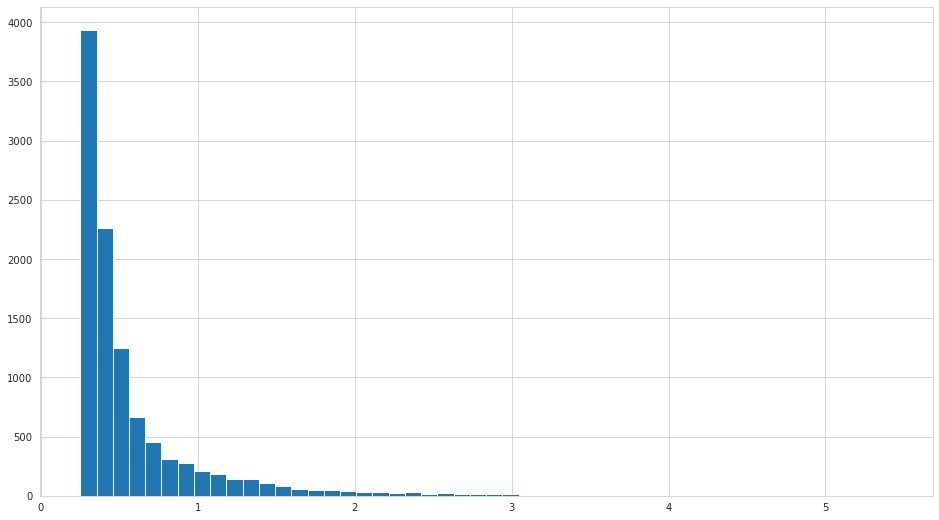

In [13]:
df_new_emiss_25["EW"].hist(bins=50)

In [14]:
df_new_emiss_25["EW"].describe()

count    10485.000000
mean         0.578771
std          0.479227
min          0.250012
25%          0.309042
50%          0.410260
75%          0.617575
max          5.423622
Name: EW, dtype: float64

In [15]:
hf_grid = h5py.File("/home/pravn/Dropbox/Masters/Research Data/wl_grid.h5", "r")
wl_grid = np.array(hf_grid["wl_grid"])
hf_grid.close()

In [22]:
df_new_emiss_25.head()

,sobject_id,1475,1476,1477,1478,1479,1480,1481,1482,1483,...,1541,1542,1543,1544,1545,1546,1547,1548,1549,EW
184,131116000501238,0.873207,0.804864,0.757102,0.789085,0.777056,0.819479,0.837544,0.771487,0.708076,...,0.750738,0.754129,0.824579,0.834770,0.810837,0.822505,0.837257,0.770928,0.802480,0.264582
344,131116001001352,1.094075,1.082184,1.088787,1.098275,1.091290,1.107136,1.123374,1.120044,1.123209,...,1.102777,1.060583,1.037816,1.043649,1.049021,1.050489,1.059230,1.071222,1.067351,2.539092
354,131116001001379,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,...,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,0.408545
415,131118002401234,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,...,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,1.340621
437,131118002401396,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,...,0.952184,0.955382,0.951590,0.953749,0.961062,0.973229,0.988212,0.976314,0.969340,0.534716


In [17]:
df_new_emiss_25_data_only = df_new_emiss_25.drop(columns=['EW','sobject_id'])

In [18]:
df_new_emiss_25_data_only_np = df_new_emiss_25_data_only.to_numpy()

In [19]:
df_new_emiss_25_data_only_np

array([[0.87320698, 0.80486417, 0.75710211, ..., 0.83725686, 0.77092758,
        0.80247988],
       [1.09407488, 1.08218396, 1.08878676, ..., 1.0592302 , 1.07122224,
        1.06735063],
       [1.01678956, 1.03371707, 1.03914097, ..., 1.03687289, 1.03514419,
        1.02727585],
       ...,
       [0.94561305, 0.95529801, 0.95642351, ..., 0.98031624, 0.97986543,
        0.97534186],
       [0.88873024, 0.89373349, 0.89334104, ..., 0.90736213, 0.92713406,
        0.93360296],
       [1.00063831, 0.9984654 , 0.99834629, ..., 1.0575973 , 1.07601055,
        1.07484511]])

In [30]:
def my_fastdtw(spec1, spec2):
    return fastdtw.fastdtw(spec1, spec2)[0]

In [31]:
distance_matrix = sd.pdist(df_new_emiss_25_data_only_np, my_fastdtw)

In [32]:
distance_matrix_square_form = sd.squareform(distance_matrix)

In [33]:
hf_dtwdistance = h5py.File("/home/pravn/Dropbox/Masters/Research Data/dtw_distances_halpha_autoencoder_3.h5","w")

In [34]:
hf_dtwdistance.create_dataset("dtw_distance", data=distance_matrix_square_form)
hf_dtwdistance.close()

In [108]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("Sample")
    plt.ylabel("Sample")
    plt.title("DTW Distance")
    plt.grid()
    plt.legend
    plt.colorbar();

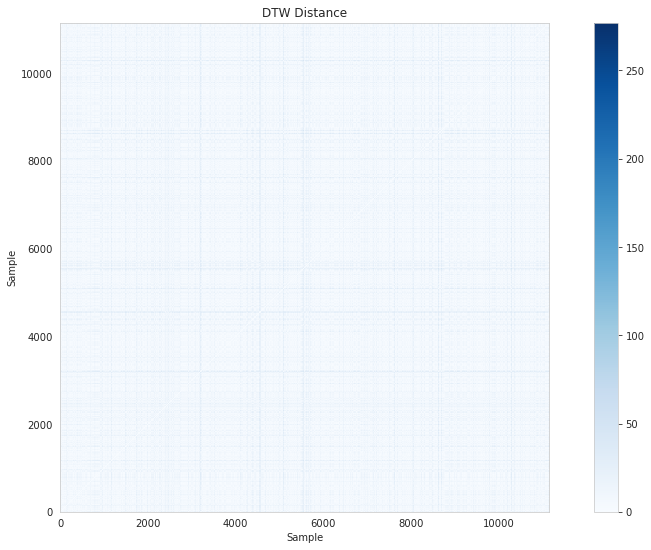

In [109]:
distance_cost_plot(distance_matrix_square_form)

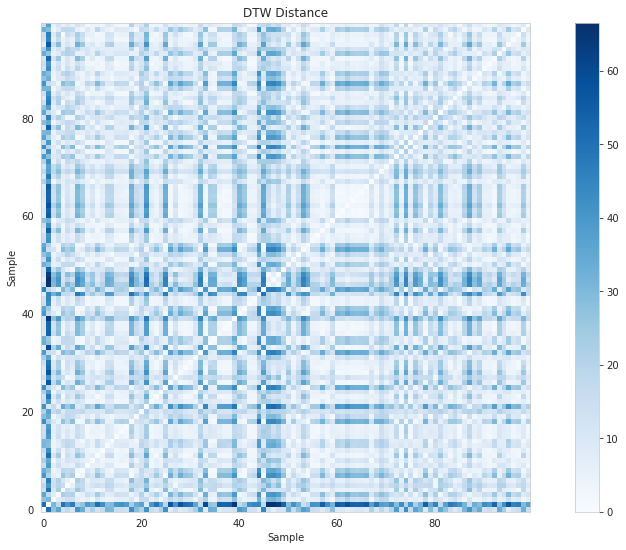

In [37]:
distance_cost_plot(distance_matrix_square_form[0:100:,0:100])

In [38]:
agglom = AgglomerativeClustering(n_clusters = 10, linkage = 'complete', affinity='precomputed')
agglom.fit(distance_matrix_square_form)
agglom.labels_

array([3, 5, 5, ..., 3, 3, 3])

In [39]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [40]:
score = silhouette_score(df_new_emiss_25_data_only_np, agglom.labels_)
print(score)

0.4490439647219464


In [41]:
old_names = df_new_emiss_25_data_only.columns.tolist()

In [42]:
new_names = wl_grid[PLOT_MASK].tolist()

In [43]:
col_rename_dict = {i:j for i,j in zip(old_names, new_names)}

In [44]:
df_new_emiss_25_data_only.rename(columns=col_rename_dict, inplace=True)

In [45]:
df_new_emiss_25_data_only

,6561.00,6561.06,6561.12,6561.18,6561.24,6561.30,6561.36,6561.42,6561.48,6561.54,...,6564.90,6564.96,6565.02,6565.08,6565.14,6565.20,6565.26,6565.32,6565.38,6565.44
184,0.873207,0.804864,0.757102,0.789085,0.777056,0.819479,0.837544,0.771487,0.708076,0.733736,...,0.819911,0.750738,0.754129,0.824579,0.834770,0.810837,0.822505,0.837257,0.770928,0.802480
344,1.094075,1.082184,1.088787,1.098275,1.091290,1.107136,1.123374,1.120044,1.123209,1.123071,...,1.087653,1.102777,1.060583,1.037816,1.043649,1.049021,1.050489,1.059230,1.071222,1.067351
354,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.059578,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276
415,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.956748,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347
437,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,0.936088,...,0.945860,0.952184,0.955382,0.951590,0.953749,0.961062,0.973229,0.988212,0.976314,0.969340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588273,1.095577,1.080673,1.061814,1.064714,1.058293,1.052399,1.070446,1.084408,1.066084,1.059513,...,1.030614,1.028179,1.003046,0.982111,0.982488,0.996599,1.006678,1.002321,0.982277,0.972831
588302,1.084897,1.069821,1.077153,1.082530,1.075968,1.074224,1.077529,1.079038,1.077107,1.073298,...,1.103199,1.077458,1.069186,1.060970,1.044236,1.038572,1.051922,1.067468,1.079094,1.062375
588320,0.945613,0.955298,0.956424,0.953472,0.953267,0.942869,0.942641,0.944629,0.943243,0.948502,...,0.977026,0.990285,0.997061,0.985958,0.978304,0.976240,0.967372,0.980316,0.979865,0.975342
588321,0.888730,0.893733,0.893341,0.882750,0.869504,0.861716,0.862673,0.875026,0.870650,0.857322,...,0.889530,0.888846,0.887492,0.897386,0.897181,0.889871,0.894677,0.907362,0.927134,0.933603


In [46]:
df_new_emiss_25_data_only["label"] = pd.Series(agglom.labels_, index = df_new_emiss_25_data_only.index)

In [47]:
df_new_emiss_25_data_only

,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,6561.540000000594,...,6564.960000000617,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label
184,0.873207,0.804864,0.757102,0.789085,0.777056,0.819479,0.837544,0.771487,0.708076,0.733736,...,0.750738,0.754129,0.824579,0.834770,0.810837,0.822505,0.837257,0.770928,0.802480,3
344,1.094075,1.082184,1.088787,1.098275,1.091290,1.107136,1.123374,1.120044,1.123209,1.123071,...,1.102777,1.060583,1.037816,1.043649,1.049021,1.050489,1.059230,1.071222,1.067351,5
354,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,5
415,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,5
437,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,0.936088,...,0.952184,0.955382,0.951590,0.953749,0.961062,0.973229,0.988212,0.976314,0.969340,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588273,1.095577,1.080673,1.061814,1.064714,1.058293,1.052399,1.070446,1.084408,1.066084,1.059513,...,1.028179,1.003046,0.982111,0.982488,0.996599,1.006678,1.002321,0.982277,0.972831,5
588302,1.084897,1.069821,1.077153,1.082530,1.075968,1.074224,1.077529,1.079038,1.077107,1.073298,...,1.077458,1.069186,1.060970,1.044236,1.038572,1.051922,1.067468,1.079094,1.062375,5
588320,0.945613,0.955298,0.956424,0.953472,0.953267,0.942869,0.942641,0.944629,0.943243,0.948502,...,0.990285,0.997061,0.985958,0.978304,0.976240,0.967372,0.980316,0.979865,0.975342,3
588321,0.888730,0.893733,0.893341,0.882750,0.869504,0.861716,0.862673,0.875026,0.870650,0.857322,...,0.888846,0.887492,0.897386,0.897181,0.889871,0.894677,0.907362,0.927134,0.933603,3


In [48]:
df_new_emiss_25_data_only["sobject_id"] = df_new_emiss_25["sobject_id"]

In [49]:
df_new_emiss_25_data_only.head()

,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,6561.540000000594,...,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label,sobject_id
184,0.873207,0.804864,0.757102,0.789085,0.777056,0.819479,0.837544,0.771487,0.708076,0.733736,...,0.754129,0.824579,0.834770,0.810837,0.822505,0.837257,0.770928,0.802480,3,131116000501238
344,1.094075,1.082184,1.088787,1.098275,1.091290,1.107136,1.123374,1.120044,1.123209,1.123071,...,1.060583,1.037816,1.043649,1.049021,1.050489,1.059230,1.071222,1.067351,5,131116001001352
354,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,5,131116001001379
415,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,5,131118002401234
437,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,0.936088,...,0.955382,0.951590,0.953749,0.961062,0.973229,0.988212,0.976314,0.969340,3,131118002401396


In [50]:
df_new_emiss_25_data_only["label"].value_counts()

3    9212
5    1193
2      29
1      17
7      13
8      10
6       4
4       3
0       2
9       2
Name: label, dtype: int64

In [51]:
df_new_emiss_25_data_only

,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,6561.540000000594,...,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label,sobject_id
184,0.873207,0.804864,0.757102,0.789085,0.777056,0.819479,0.837544,0.771487,0.708076,0.733736,...,0.754129,0.824579,0.834770,0.810837,0.822505,0.837257,0.770928,0.802480,3,131116000501238
344,1.094075,1.082184,1.088787,1.098275,1.091290,1.107136,1.123374,1.120044,1.123209,1.123071,...,1.060583,1.037816,1.043649,1.049021,1.050489,1.059230,1.071222,1.067351,5,131116001001352
354,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,5,131116001001379
415,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,5,131118002401234
437,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,0.936088,...,0.955382,0.951590,0.953749,0.961062,0.973229,0.988212,0.976314,0.969340,3,131118002401396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588273,1.095577,1.080673,1.061814,1.064714,1.058293,1.052399,1.070446,1.084408,1.066084,1.059513,...,1.003046,0.982111,0.982488,0.996599,1.006678,1.002321,0.982277,0.972831,5,190211002201163
588302,1.084897,1.069821,1.077153,1.082530,1.075968,1.074224,1.077529,1.079038,1.077107,1.073298,...,1.069186,1.060970,1.044236,1.038572,1.051922,1.067468,1.079094,1.062375,5,190211002201313
588320,0.945613,0.955298,0.956424,0.953472,0.953267,0.942869,0.942641,0.944629,0.943243,0.948502,...,0.997061,0.985958,0.978304,0.976240,0.967372,0.980316,0.979865,0.975342,3,171208003101213
588321,0.888730,0.893733,0.893341,0.882750,0.869504,0.861716,0.862673,0.875026,0.870650,0.857322,...,0.887492,0.897386,0.897181,0.889871,0.894677,0.907362,0.927134,0.933603,3,171208003101223


In [52]:
df_masked = df_new_emiss_25_data_only

Int64Index([153309, 161537, 170478, 211266, 218665, 218755, 220454, 221312,
            283385, 305119, 305364, 319698, 321613, 368774, 404715, 581213,
            582533],
           dtype='int64')


Text(6562.78, 2.5, 'Hα')

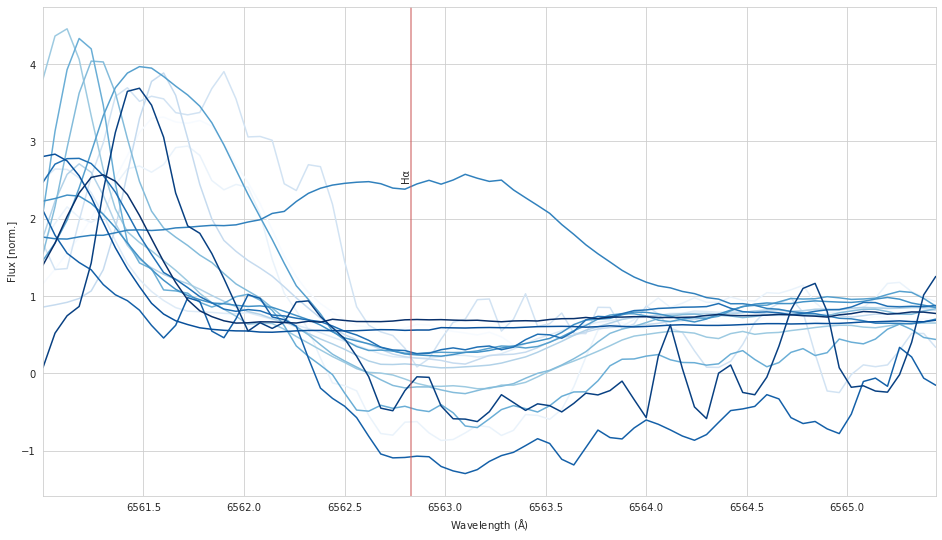

In [55]:
CLASS = 1
df_masked_label = df_masked.loc[df_masked["label"]==CLASS]
print(df_masked_label.index)
ax = (df_masked.loc[df_masked['label'] == CLASS].drop(columns=['label','sobject_id']).T).plot(
    legend=False, 
    xlabel = "Wavelength ($\mathrm{\AA}$)", 
    ylabel = "Flux [norm.]",
    #xticks = wl_grid[PLOT_MASK],
    xlim = (wl_grid[PLOT_MASK].min(),wl_grid[PLOT_MASK].max()),
    colormap = "Blues"
    )
halpha_line = ax.axvline(x=6562.83, color='indianred', label="coral", alpha=0.7)
ax.text(6562.78,2.5,"Hα", rotation=90)

Appendix of Dead Code

In [11]:
part_70 = df_new_emiss_25.sample(frac=0.7)

In [12]:
rest_part_70 = df_new_emiss_25.drop(part_70.index)

In [13]:
part_70["sobject_id"].count()

7437

In [14]:
rest_part_70["sobject_id"].count()

3188

In [15]:
part_70_data_only = part_70.drop(columns=['EW','sobject_id'])
rest_part_70_data_only = rest_part_70.drop(columns=['EW','sobject_id'])

In [16]:
part_70_data_only_np = part_70_data_only.to_numpy()
rest_part_70_data_only_np = rest_part_70_data_only.to_numpy()

In [17]:
def my_fastdtw(spec1, spec2):
    return fastdtw.fastdtw(spec1, spec2)[0]

In [18]:
distance_matrix_rest_70 = sd.pdist(rest_part_70_data_only_np, my_fastdtw)

DTAI Test 

In [11]:
df_new_emiss_25_data_only = df_new_emiss_25.drop(columns=['EW','sobject_id'])

In [28]:
df_new_emiss_25_data_only_np = df_new_emiss_25_data_only.to_numpy()

In [36]:
df_new_emiss_25_data_only_np 

array([[0.87320698, 0.80486417, 0.75710211, ..., 0.83725686, 0.77092758,
        0.80247988],
       [1.09407488, 1.08218396, 1.08878676, ..., 1.0592302 , 1.07122224,
        1.06735063],
       [1.01678956, 1.03371707, 1.03914097, ..., 1.03687289, 1.03514419,
        1.02727585],
       ...,
       [0.94561305, 0.95529801, 0.95642351, ..., 0.98031624, 0.97986543,
        0.97534186],
       [0.88873024, 0.89373349, 0.89334104, ..., 0.90736213, 0.92713406,
        0.93360296],
       [1.00063831, 0.9984654 , 0.99834629, ..., 1.0575973 , 1.07601055,
        1.07484511]])

In [37]:
from dtaidistance import dtw
ds = dtw.distance_matrix_fast(df_new_emiss_25_data_only_np )

In [38]:
ds

array([[0.        , 4.17040913, 3.09822439, ..., 1.80268937, 1.83746225,
        1.9162478 ],
       [4.17040913, 0.        , 5.14256966, ..., 6.83805   , 7.17756957,
        6.31816426],
       [3.09822439, 5.14256966, 0.        , ..., 1.79685294, 1.82795859,
        1.68728177],
       ...,
       [1.80268937, 6.83805   , 1.79685294, ..., 0.        , 0.34009036,
        0.38831614],
       [1.83746225, 7.17756957, 1.82795859, ..., 0.34009036, 0.        ,
        0.77785053],
       [1.9162478 , 6.31816426, 1.68728177, ..., 0.38831614, 0.77785053,
        0.        ]])

In [39]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.colorbar();

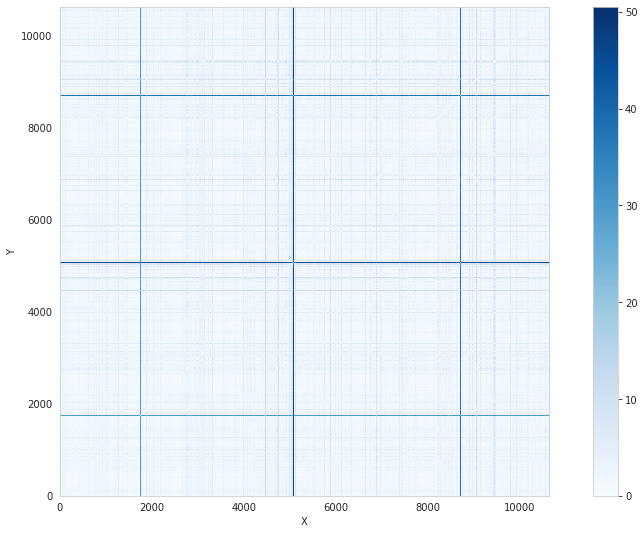

In [40]:
distance_cost_plot(ds)

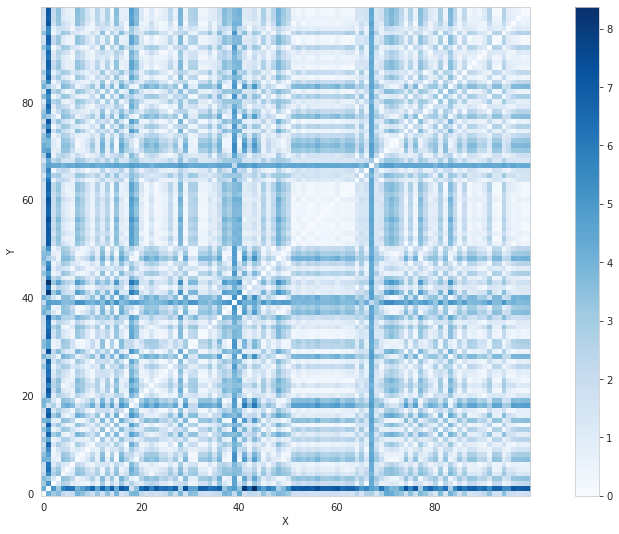

In [41]:
distance_cost_plot(ds[0:100:,0:100])

In [80]:
agglom = AgglomerativeClustering(n_clusters = 20, linkage = 'complete', affinity='precomputed')
agglom.fit(ds)
agglom.labels_

array([2, 6, 2, ..., 2, 2, 2])

In [81]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [82]:
score = silhouette_score(df_new_emiss_25_data_only_np , agglom.labels_)
print(score)

0.40248513867982344


In [83]:
old_names = df_new_emiss_25_data_only.columns.tolist()

In [84]:
new_names = wl_grid[PLOT_MASK].tolist()

In [85]:
col_rename_dict = {i:j for i,j in zip(old_names, new_names)}

In [86]:
df_new_emiss_25_data_only.rename(columns=col_rename_dict, inplace=True)

In [87]:
df_new_emiss_25_data_only

,6561.00,6561.06,6561.12,6561.18,6561.24,6561.30,6561.36,6561.42,6561.48,6561.54,...,6564.90,6564.96,6565.02,6565.08,6565.14,6565.20,6565.26,6565.32,6565.38,6565.44
184,0.873207,0.804864,0.757102,0.789085,0.777056,0.819479,0.837544,0.771487,0.708076,0.733736,...,0.819911,0.750738,0.754129,0.824579,0.834770,0.810837,0.822505,0.837257,0.770928,0.802480
344,1.094075,1.082184,1.088787,1.098275,1.091290,1.107136,1.123374,1.120044,1.123209,1.123071,...,1.087653,1.102777,1.060583,1.037816,1.043649,1.049021,1.050489,1.059230,1.071222,1.067351
354,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.059578,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276
415,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.956748,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347
463,1.046427,1.066219,1.111588,1.128791,1.090689,1.048772,1.042966,1.068899,1.107123,1.134540,...,1.060275,1.042947,1.040967,1.009793,0.985055,1.007708,1.053111,1.064764,1.036411,1.008668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588273,1.095577,1.080673,1.061814,1.064714,1.058293,1.052399,1.070446,1.084408,1.066084,1.059513,...,1.030614,1.028179,1.003046,0.982111,0.982488,0.996599,1.006678,1.002321,0.982277,0.972831
588302,1.084897,1.069821,1.077153,1.082530,1.075968,1.074224,1.077529,1.079038,1.077107,1.073298,...,1.103199,1.077458,1.069186,1.060970,1.044236,1.038572,1.051922,1.067468,1.079094,1.062375
588320,0.945613,0.955298,0.956424,0.953472,0.953267,0.942869,0.942641,0.944629,0.943243,0.948502,...,0.977026,0.990285,0.997061,0.985958,0.978304,0.976240,0.967372,0.980316,0.979865,0.975342
588321,0.888730,0.893733,0.893341,0.882750,0.869504,0.861716,0.862673,0.875026,0.870650,0.857322,...,0.889530,0.888846,0.887492,0.897386,0.897181,0.889871,0.894677,0.907362,0.927134,0.933603


In [88]:
df_new_emiss_25_data_only["label"] = pd.Series(agglom.labels_, index = df_new_emiss_25_data_only.index)

In [89]:
df_new_emiss_25_data_only

,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,6561.540000000594,...,6564.960000000617,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label
184,0.873207,0.804864,0.757102,0.789085,0.777056,0.819479,0.837544,0.771487,0.708076,0.733736,...,0.750738,0.754129,0.824579,0.834770,0.810837,0.822505,0.837257,0.770928,0.802480,2
344,1.094075,1.082184,1.088787,1.098275,1.091290,1.107136,1.123374,1.120044,1.123209,1.123071,...,1.102777,1.060583,1.037816,1.043649,1.049021,1.050489,1.059230,1.071222,1.067351,6
354,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,2
415,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,2
463,1.046427,1.066219,1.111588,1.128791,1.090689,1.048772,1.042966,1.068899,1.107123,1.134540,...,1.042947,1.040967,1.009793,0.985055,1.007708,1.053111,1.064764,1.036411,1.008668,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588273,1.095577,1.080673,1.061814,1.064714,1.058293,1.052399,1.070446,1.084408,1.066084,1.059513,...,1.028179,1.003046,0.982111,0.982488,0.996599,1.006678,1.002321,0.982277,0.972831,2
588302,1.084897,1.069821,1.077153,1.082530,1.075968,1.074224,1.077529,1.079038,1.077107,1.073298,...,1.077458,1.069186,1.060970,1.044236,1.038572,1.051922,1.067468,1.079094,1.062375,2
588320,0.945613,0.955298,0.956424,0.953472,0.953267,0.942869,0.942641,0.944629,0.943243,0.948502,...,0.990285,0.997061,0.985958,0.978304,0.976240,0.967372,0.980316,0.979865,0.975342,2
588321,0.888730,0.893733,0.893341,0.882750,0.869504,0.861716,0.862673,0.875026,0.870650,0.857322,...,0.888846,0.887492,0.897386,0.897181,0.889871,0.894677,0.907362,0.927134,0.933603,2


In [90]:
df_new_emiss_25_data_only["label"].value_counts()

2     9831
8      216
0      206
6      187
4       95
16      22
3       13
7       11
18      11
10       7
1        6
15       4
13       4
5        3
9        2
12       2
11       2
17       1
14       1
19       1
Name: label, dtype: int64

Int64Index([156355, 157339, 206598, 275988, 277052, 280168, 280390, 281430,
            281458, 281572, 281722, 281822, 281865, 282499, 282848, 283043,
            283421, 477676, 477881, 478453, 559988, 560134],
           dtype='int64')


Text(6562.78, 2.5, 'Hα')

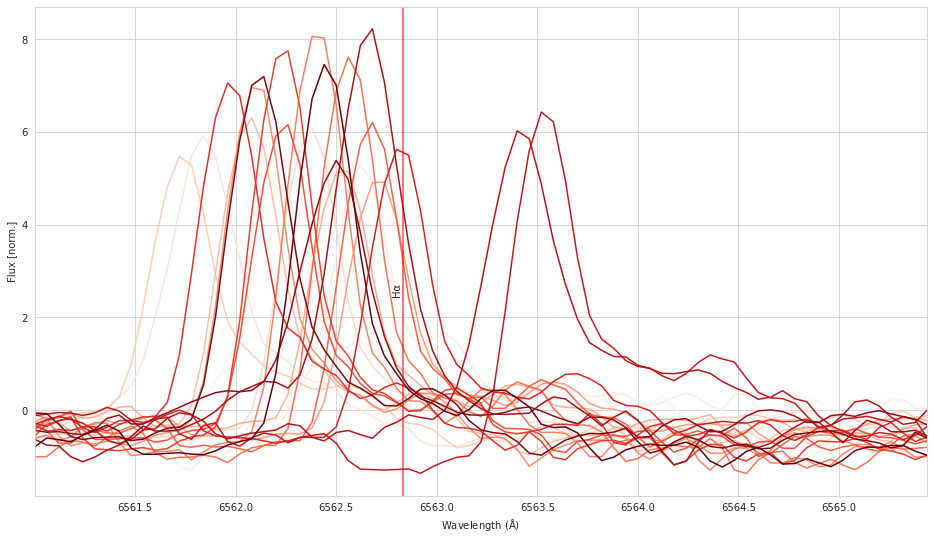

In [100]:
CLASS = 16
df_masked_label = df_new_emiss_25_data_only.loc[df_new_emiss_25_data_only["label"]==CLASS]
print(df_masked_label.index)
ax = (df_new_emiss_25_data_only.loc[df_new_emiss_25_data_only['label'] == CLASS].drop(columns=['label']).T).plot(
    legend=False, 
    xlabel = "Wavelength ($\mathrm{\AA}$)", 
    ylabel = "Flux [norm.]",
    #xticks = wl_grid[PLOT_MASK],
    xlim = (wl_grid[PLOT_MASK].min(),wl_grid[PLOT_MASK].max()),
    colormap = "Reds"
    )
halpha_line = ax.axvline(x=6562.83, color='red', label="coral", alpha=0.7)
ax.text(6562.78,2.5,"Hα", rotation=90)